# Serbian Parliament NLP analysis

## Setup & Imports

In [1]:
# Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import logging
from gensim import corpora, models
import stanza
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [2]:
# Stanza pipeline
nlp = stanza.Pipeline("sr", processors="tokenize,pos,lemma", use_gpu=False)

2025-05-11 10:17:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-05-11 10:17:19 INFO: Downloaded file to /home/vuk/stanza_resources/resources.json
2025-05-11 10:17:19 INFO: Loading these models for language: sr (Serbian):
| Processor | Package      |
----------------------------
| tokenize  | set          |
| pos       | set_nocharlm |
| lemma     | set_nocharlm |

2025-05-11 10:17:19 INFO: Using device: cpu
2025-05-11 10:17:19 INFO: Loading: tokenize
2025-05-11 10:17:20 INFO: Loading: pos
2025-05-11 10:17:21 INFO: Loading: lemma
2025-05-11 10:17:21 INFO: Done loading processors!


In [3]:
# Config
DATA_PATH = "/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/02 interim/speeches.json"
STOPWORDS_PATH = "/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/04 metadata/serbian_stopwords.txt"
NUM_TOPICS = 10

## Data Loading

In [4]:
def load_data(path):
    try:
        with open(path, encoding="utf-8") as f:
            data = json.load(f)
        logging.info(f"Loaded {len(data)} records from {path}")
        return pd.DataFrame(data)
    except FileNotFoundError:
        logging.error(f"File not found: {path}")
        return pd.DataFrame()

In [5]:
def load_stopwords(path):
    with open(path, encoding="utf-8") as f:
        return set(line.strip().lower() for line in f if line.strip())

In [6]:
# Load
df = load_data(DATA_PATH)
stopwords = load_stopwords(STOPWORDS_PATH)

## Preprocessing

In [7]:
def tokenize_and_lemmatize(text, stopwords):
    doc = nlp(text)
    return [
        word.lemma.lower()
        for sent in doc.sentences
        for word in sent.words
        if word.lemma and word.lemma.lower() not in stopwords and len(word.lemma) > 3
    ]

In [8]:
# Basic Cleaning
df['speech'] = df['speech'].astype(str)
df['speaker'] = df['speaker'].astype(str)
df['speech_len'] = df['speech'].str.len()

In [9]:
# Tokenize and Clean
df['clean_tokens'] = df['speech'].apply(lambda x: tokenize_and_lemmatize(x, stopwords))
df['clean_text'] = df['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

In [10]:
df.to_json("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/02 interim/lemmatized_speeches.json", orient="records", force_ascii=False)

## Visualizations

In [11]:
def plot_wordcloud(frequencies, title='Most Common Non-Stop Words'):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(frequencies)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [12]:
def plot_histogram(data, title, xlabel, ylabel, bins=20, xlim=None):
    plt.figure(figsize=(8, 5))
    data.hist(bins=bins, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim:
        plt.xlim(*xlim)
    plt.grid(True)
    plt.show()

## WordCloud + Length Distribution

In [13]:
# Word Frequency
word_freq = Counter()
df['clean_tokens'].apply(lambda tokens: word_freq.update(tokens))

0       None
1       None
2       None
3       None
4       None
        ... 
6573    None
6574    None
6575    None
6576    None
6577    None
Name: clean_tokens, Length: 6578, dtype: object

In [14]:
df['speech_len'] = df['speech'].str.len()

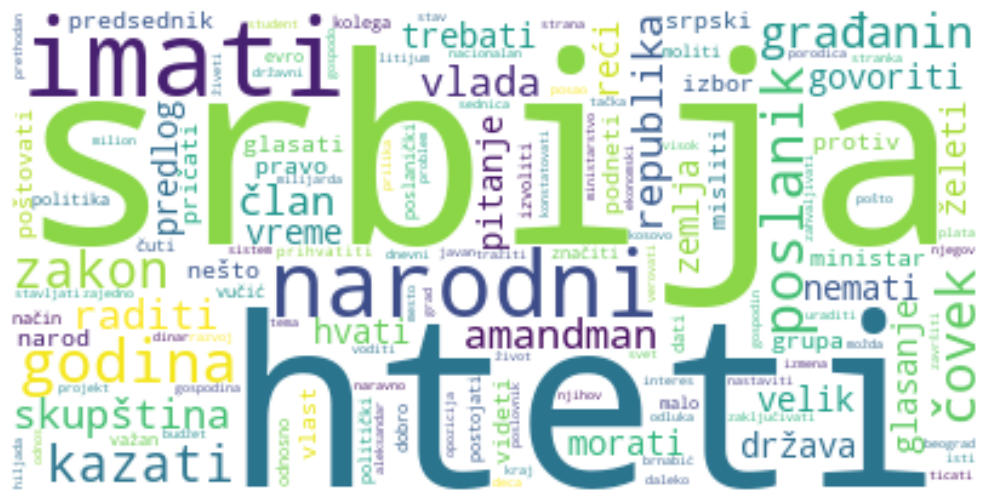

In [17]:
# Create the word cloud
wordcloud = WordCloud(
    background_color="white",
    max_words=500,
    colormap="viridis"
).generate_from_frequencies(word_freq)

# Plot and save
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/wordcloud_serbia.png", dpi=300)
plt.show()

In [18]:
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

In [19]:
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])

# Sort by frequency descending
top_words = word_freq_df.sort_values(by='frequency', ascending=False)

# Display top 20
top_words.head(20)

,word,frequency
9,srbija,13004
234,hteti,12563
235,imati,10284
3,narodni,8778
21,godina,7686
4,poslanik,6285
438,čovek,5509
654,zakon,4957
229,kazati,4838
201,građanin,4748


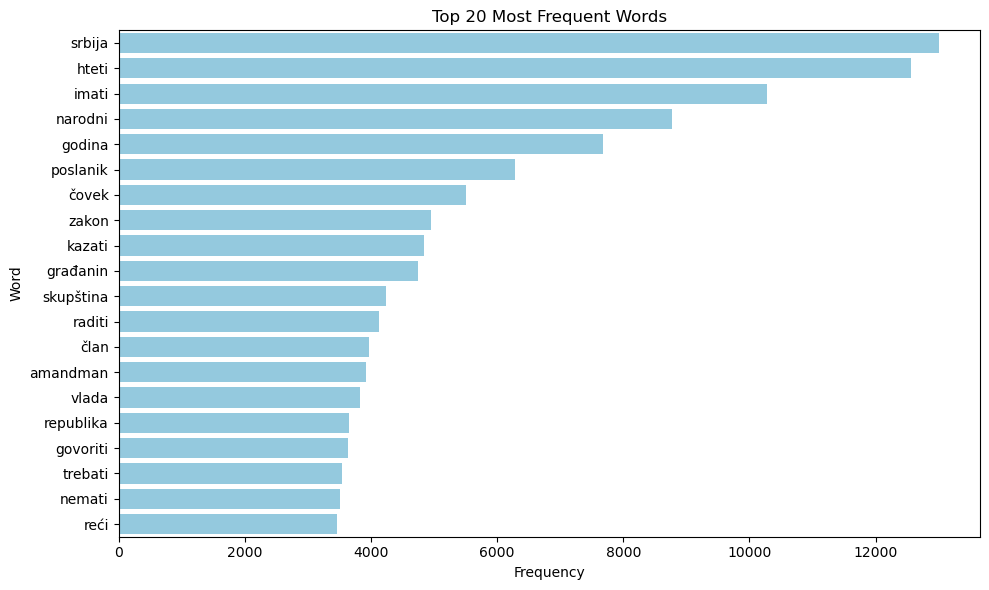

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words.head(20), x='frequency', y='word', color='skyblue')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.savefig("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/top_words_serbia.png", dpi=300)
plt.show()

In [21]:
word_freq_df.to_csv("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/02 interim/word_frequencies.csv", index=False)

In [22]:
if 'speech_len' not in df.columns:
    df['speech_len'] = df['speech'].str.len()

# Keep only needed columns (optional)
speech_len_df = df[['speaker', 'speech_len']]

In [23]:
speech_len_df.to_csv("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/02 interim/speech_lengths.csv", index=False)

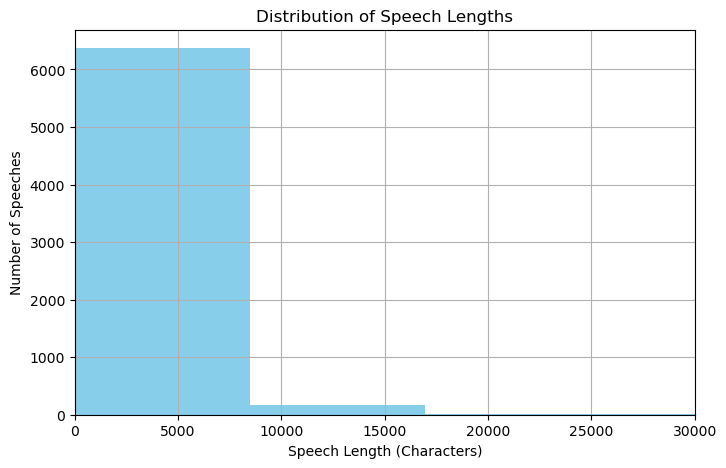

<Figure size 640x480 with 0 Axes>

In [24]:
plot_histogram(df['speech_len'], 'Distribution of Speech Lengths', 'Speech Length (Characters)', 'Number of Speeches', xlim=(0, 30000))
plt.savefig("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/speech_lengths.png", dpi=300)
plt.show()

In [25]:
top_speakers_by_count = df['speaker'].value_counts().reset_index()
top_speakers_by_count.columns = ['speaker', 'num_speeches']
print(top_speakers_by_count.head(15))

                 speaker  num_speeches
0            ANA BRNABIĆ          1762
1       SNEŽANA PAUNOVIĆ           623
2           MARINA RAGUŠ           454
3        MILENKO JOVANOV           328
4   ALEKSANDAR JOVANOVIĆ           268
5       STOJAN RADENOVIĆ           258
6        RADOMIR LAZOVIĆ           125
7      SRĐAN MILIVOJEVIĆ           106
8     MILOŠ PARANDILOVIĆ            95
9          ZORAN LUTOVAC            90
10        MARINIKA TEPIĆ            86
11         MILOŠ VUČEVIĆ            79
12    BORISLAV NOVAKOVIĆ            77
13   DANIJELA NESTOROVIĆ            74
14          ELVIRA KOVAČ            57


In [26]:
top_speakers_by_length = df.groupby('speaker')['speech_len'].sum().sort_values(ascending=False).reset_index()
top_speakers_by_length.columns = ['speaker', 'total_speech_len']
print(top_speakers_by_length.head(15))

                        speaker  total_speech_len
0                   ANA BRNABIĆ            799335
1               MILENKO JOVANOV            696929
2                 MILOŠ VUČEVIĆ            482097
3              SNEŽANA PAUNOVIĆ            470949
4           DANIJELA NESTOROVIĆ            283581
5   DUBRAVKA ĐEDOVIĆ HANDANOVIĆ            262915
6         ALEKSANDAR MARTINOVIĆ            218080
7                   SINIŠA MALI            213075
8              ŽIVOTA STARČEVIĆ            151432
9                  MARINA RAGUŠ            146521
10         ALEKSANDAR JOVANOVIĆ            144590
11             MIROSLAV ALEKSIĆ            141545
12              RADOMIR LAZOVIĆ            138195
13           MARIJAN RISTIČEVIĆ            133678
14             ALEKSANDAR VULIN            133602


In [27]:
speaker_stats = df.groupby('speaker').agg(
    num_speeches=('speech', 'count'),
    total_speech_len=('speech_len', 'sum'),
    avg_speech_len=('speech_len', 'mean')
).sort_values(by='num_speeches', ascending=False).reset_index()

print(speaker_stats.head(15))

                 speaker  num_speeches  total_speech_len  avg_speech_len
0            ANA BRNABIĆ          1762            799335      453.652100
1       SNEŽANA PAUNOVIĆ           623            470949      755.937400
2           MARINA RAGUŠ           454            146521      322.733480
3        MILENKO JOVANOV           328            696929     2124.783537
4   ALEKSANDAR JOVANOVIĆ           268            144590      539.514925
5       STOJAN RADENOVIĆ           258             53715      208.197674
6        RADOMIR LAZOVIĆ           125            138195     1105.560000
7      SRĐAN MILIVOJEVIĆ           106            109917     1036.952830
8     MILOŠ PARANDILOVIĆ            95             76846      808.905263
9          ZORAN LUTOVAC            90             89047      989.411111
10        MARINIKA TEPIĆ            86             95409     1109.406977
11         MILOŠ VUČEVIĆ            79            482097     6102.493671
12    BORISLAV NOVAKOVIĆ            77             

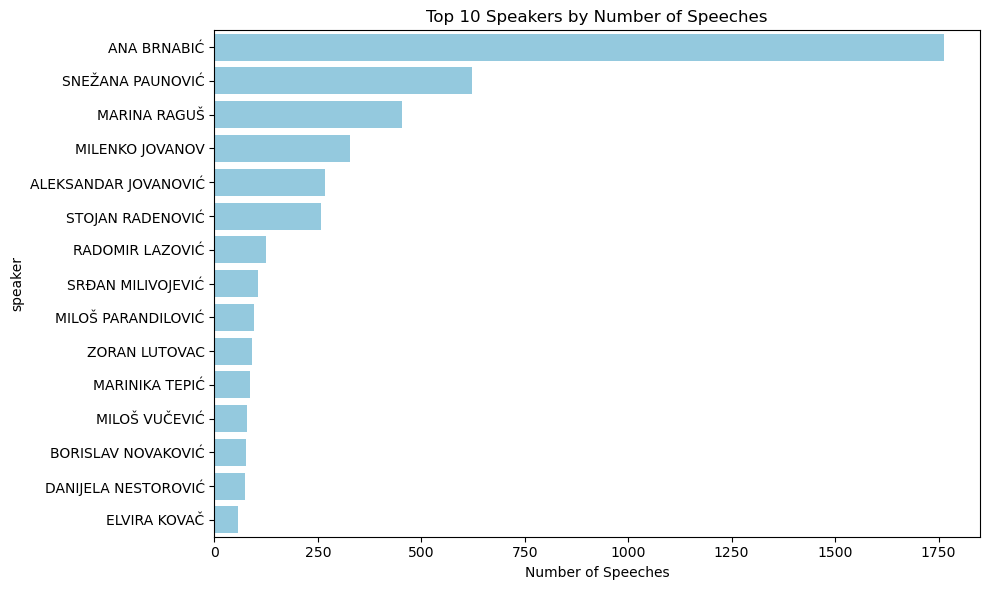

In [ ]:
top10 = speaker_stats.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='num_speeches', y='speaker', color='skyblue')
plt.title("Top 10 Speakers by Number of Speeches")
plt.xlabel("Number of Speeches")
plt.tight_layout()
plt.savefig("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/top_speakers.png", dpi=300)
plt.show()

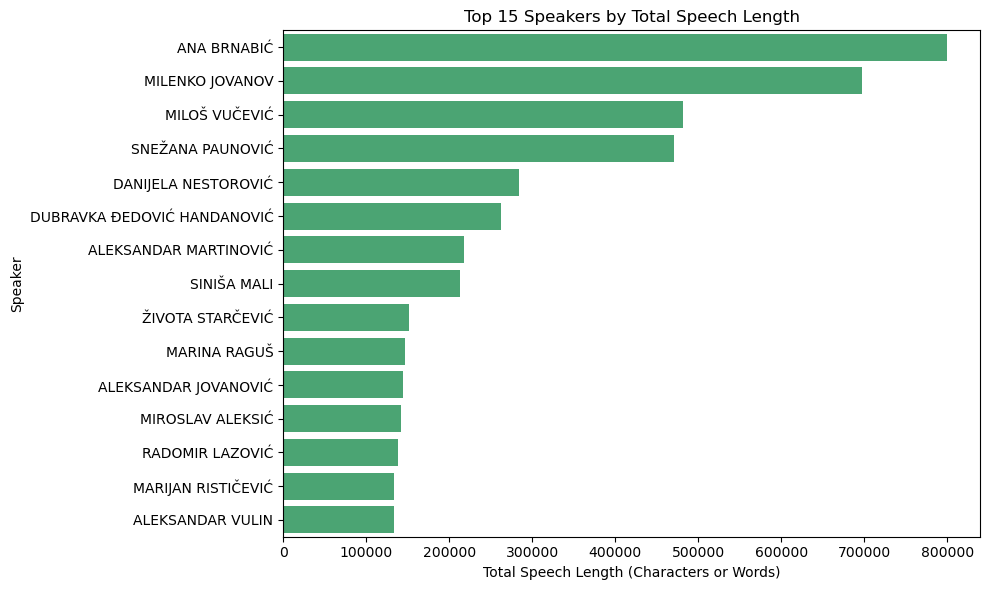

In [29]:
# Top 15 verbose speakers
top15_length = top_speakers_by_length.head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top15_length, x='total_speech_len', y='speaker', color='mediumseagreen')
plt.title("Top 15 Speakers by Total Speech Length")
plt.xlabel("Total Speech Length (Characters or Words)")
plt.ylabel("Speaker")
plt.tight_layout()
plt.savefig("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/top_speakers_2.png", dpi=300)
plt.show()

## Topic Modeling

In [30]:
import logging
logging.getLogger('gensim').setLevel(logging.WARNING)

In [31]:
def topic_modeling(texts, num_topics=10):
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
    return lda, dictionary, corpus

In [32]:
lda_model, dictionary, corpus = topic_modeling(df['clean_tokens'].tolist(), NUM_TOPICS)

# Print topics
for idx, topic in lda_model.print_topics(-1, num_words=10):
    print(f"Topic #{idx}:")
    for term in topic.split(" + "):
        weight, word = term.split("*")
        word_clean = word.strip().strip('"')
        print(f"  {float(weight):.3f} {word_clean}")
    print()

Topic #0:
  0.016 zakon
  0.011 godina
  0.010 srbija
  0.010 imati
  0.009 hteti
  0.007 član
  0.007 ministarstvo
  0.006 obrazovanje
  0.006 građanin
  0.005 pravo

Topic #1:
  0.025 litijum
  0.017 godina
  0.015 zakon
  0.013 srbija
  0.012 rudnik
  0.012 tinto
  0.011 projekt
  0.011 životan
  0.011 sredina
  0.010 građanin

Topic #2:
  0.026 srbija
  0.015 godina
  0.015 hteti
  0.011 velik
  0.011 imati
  0.009 republika
  0.008 razvoj
  0.007 država
  0.007 zemlja
  0.006 važan

Topic #3:
  0.025 hteti
  0.019 srbija
  0.015 čovek
  0.014 imati
  0.010 kazati
  0.008 vlada
  0.008 građanin
  0.007 raditi
  0.007 trebati
  0.007 govoriti

Topic #4:
  0.008 porođaj
  0.007 naslednik
  0.006 počast
  0.005 porodiljski
  0.004 dirati
  0.004 bolovanje
  0.003 tolerantnost
  0.003 dojati
  0.002 izuzimati
  0.002 trudan

Topic #5:
  0.054 imati
  0.047 hvati
  0.047 izvoliti
  0.031 narodni
  0.030 poslanik
  0.015 dragan
  0.013 odsutan
  0.012 gospodin
  0.011 protiv
  0.010 alek

## Sentiment Analysis

In [33]:
sentiment_df = pd.read_csv("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/03 external/serbian_sentiment_latin.csv")

In [34]:
sentiment_df = sentiment_df.drop_duplicates(subset=["Serbian Word"])
sentiment_df.set_index("Serbian Word", inplace=True)
sentiment_dict = sentiment_df.to_dict(orient="index")

In [35]:
def get_emotion_scores(tokens, lexicon):
    scores = np.zeros(len(next(iter(lexicon.values()))))
    for token in tokens:
        if token in lexicon:
            scores += np.array(list(lexicon[token].values()))
    return scores

In [36]:
import numpy as np
emotion_columns = sentiment_df.columns.tolist()

df[emotion_columns] = df['clean_tokens'].apply(lambda tokens: pd.Series(get_emotion_scores(tokens, sentiment_dict)))

In [37]:
# Add a column with the dominant emotion
df['dominant_emotion'] = df[emotion_columns].idxmax(axis=1)

# Or just sum total emotion occurrence across all speeches
total_emotions = df[emotion_columns].sum().sort_values(ascending=False)
print(total_emotions)

positive        64847.0
trust           51186.0
negative        38856.0
fear            23808.0
anticipation    19586.0
anger           15168.0
sadness         13698.0
joy             12311.0
surprise         7484.0
disgust          6387.0
dtype: float64


In [38]:
party_map = pd.read_csv("/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/04 metadata/party_map.csv")
df['speaker'] = df['speaker'].str.upper().str.strip()
party_map['speaker'] = party_map['speaker'].str.upper().str.strip()

df = df.merge(party_map, on='speaker', how='left')

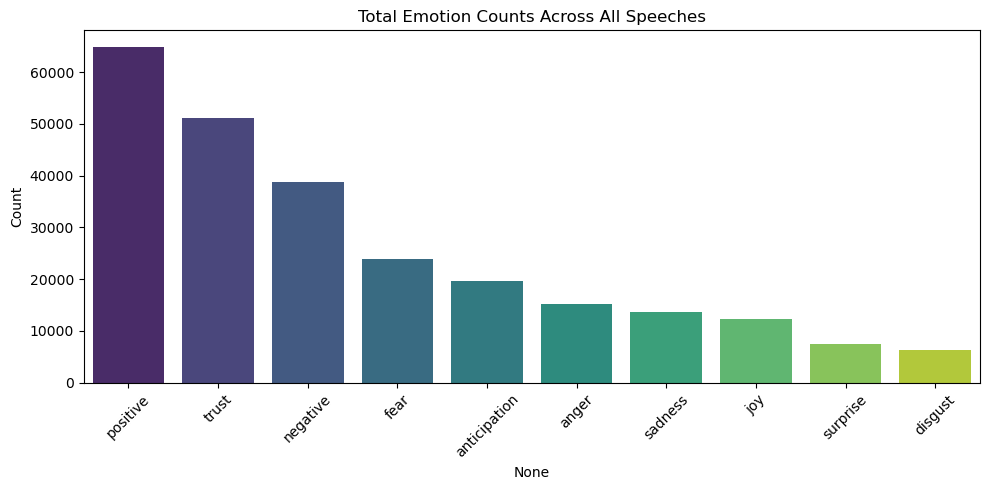

In [ ]:
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

total_emotions = df[emotion_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=total_emotions.index, y=total_emotions.values, hue=total_emotions.index, palette="viridis", dodge=False, legend=False)
plt.title("Total Emotion Counts Across All Speeches")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Group by party
party_emotions = df.groupby('party')[emotion_cols].sum()

# Normalize if you want relative proportions
party_emotions_norm = party_emotions.div(party_emotions.sum(axis=1), axis=0)

In [43]:
party_emotions_long = party_emotions_norm.reset_index().melt(
    id_vars='party',
    var_name='emotion',
    value_name='score'
)

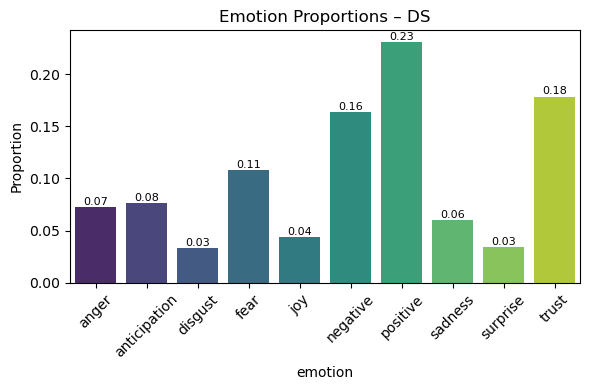

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_ds.png


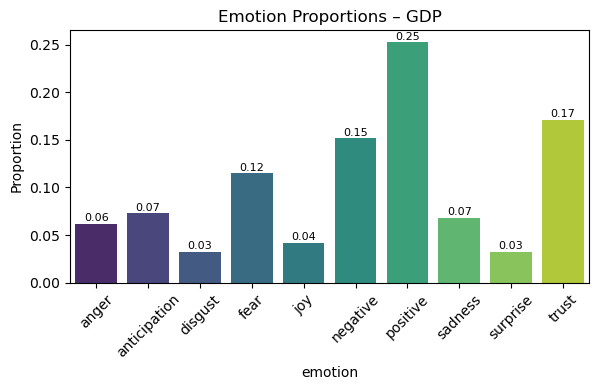

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_gdp.png


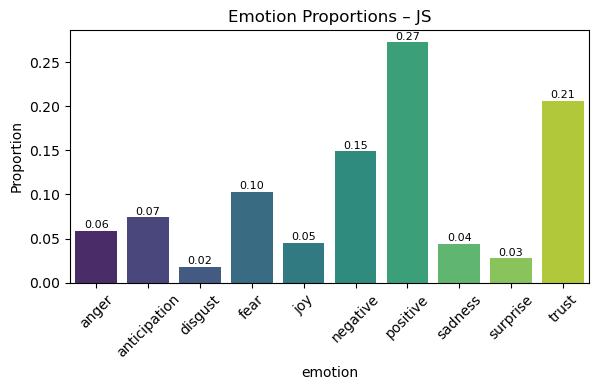

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_js.png


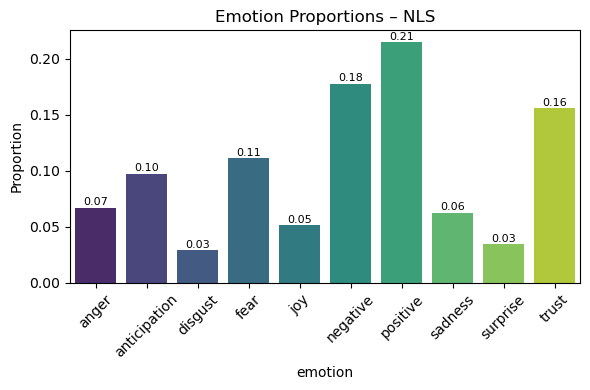

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_nls.png


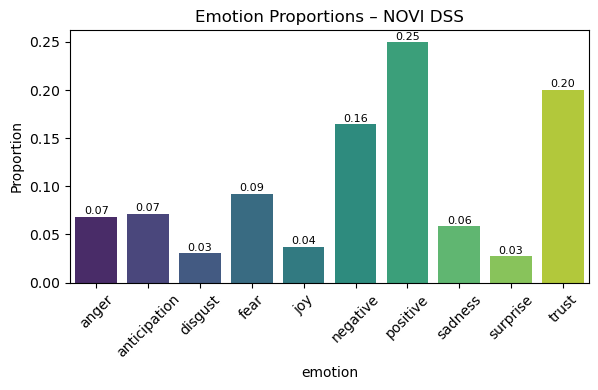

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_novi_dss.png


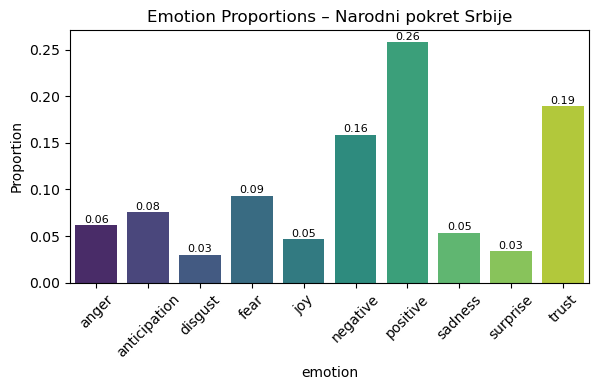

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_narodni_pokret_srbije.png


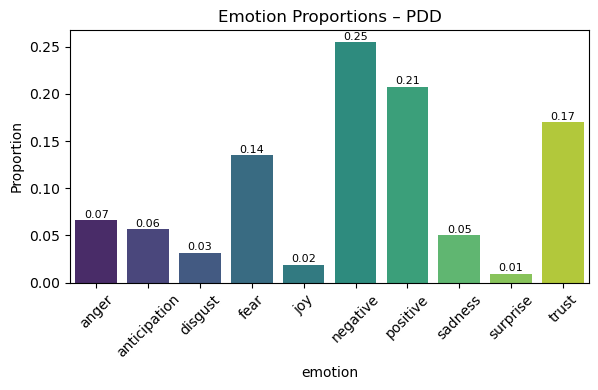

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_pdd.png


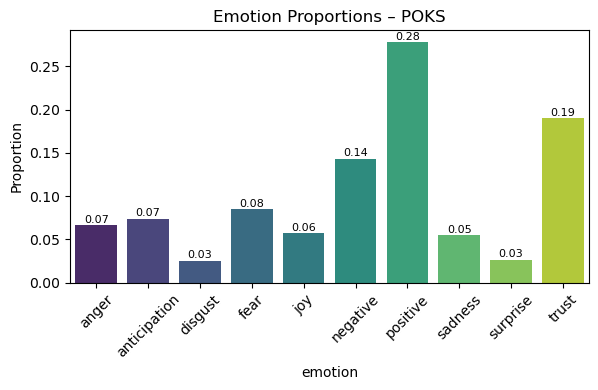

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_poks.png


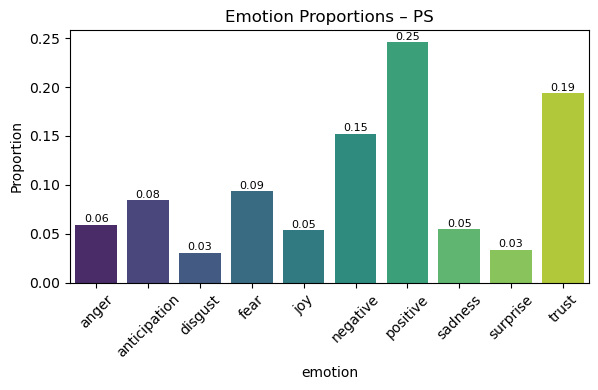

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_ps.png


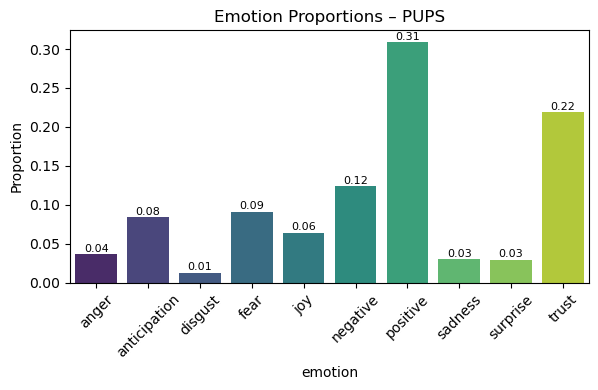

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_pups.png


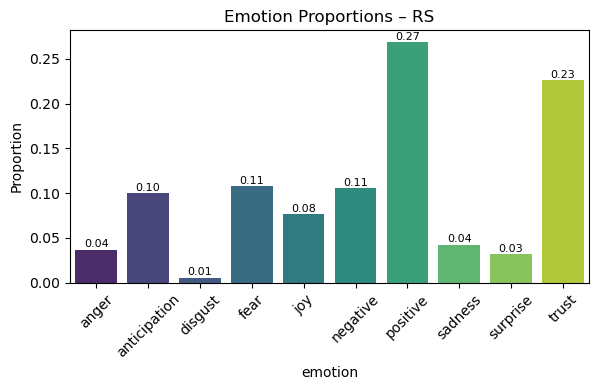

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_rs.png


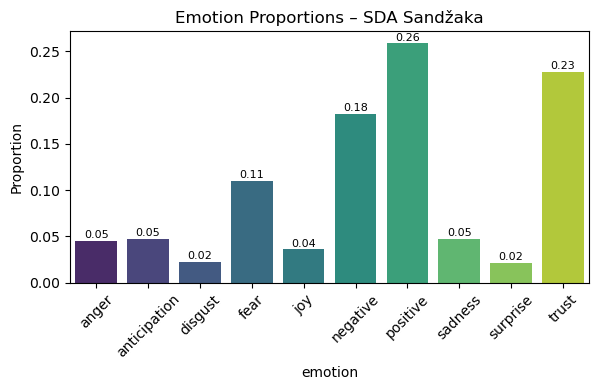

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_sda_sandžaka.png


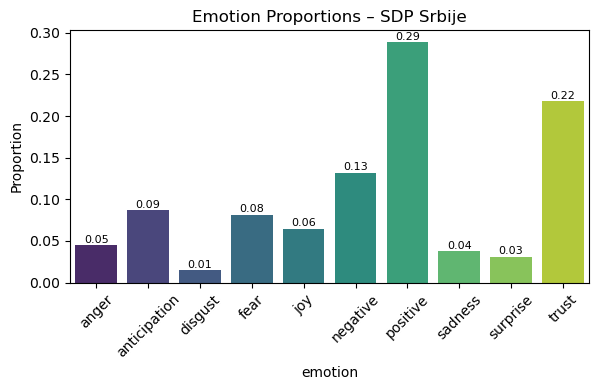

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_sdp_srbije.png


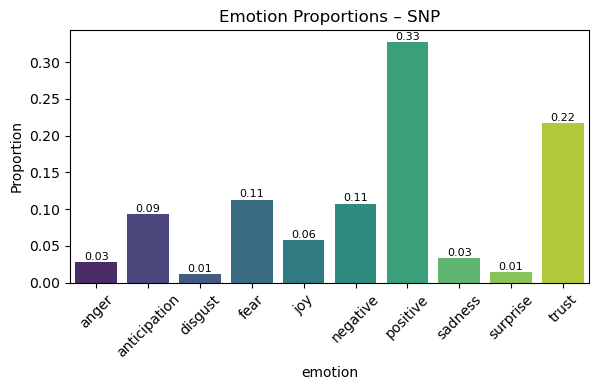

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_snp.png


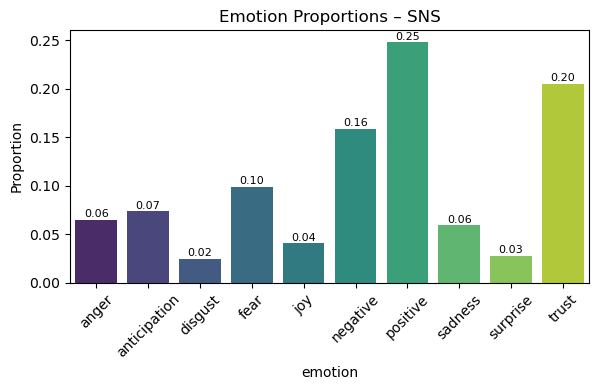

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_sns.png


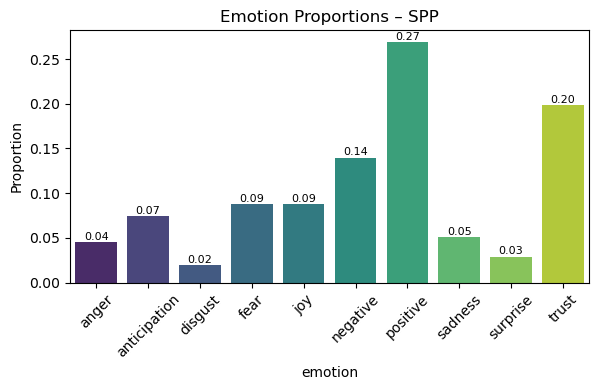

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_spp.png


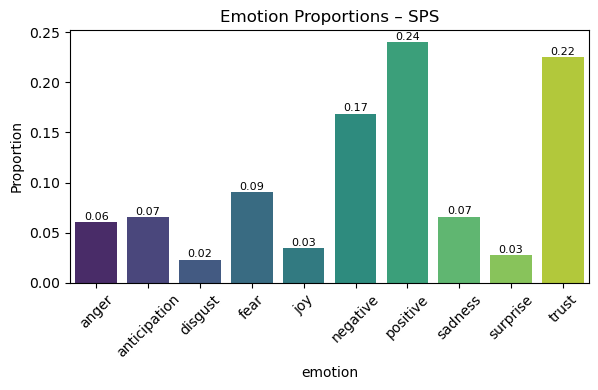

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_sps.png


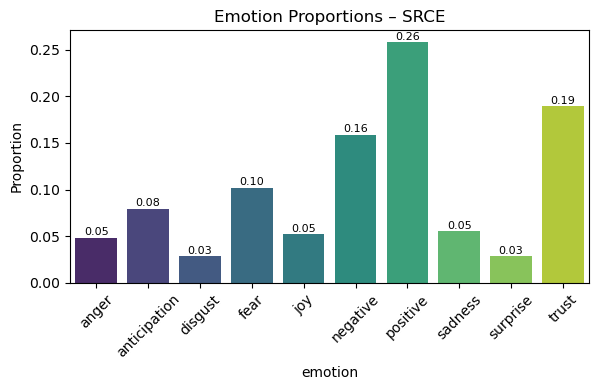

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_srce.png


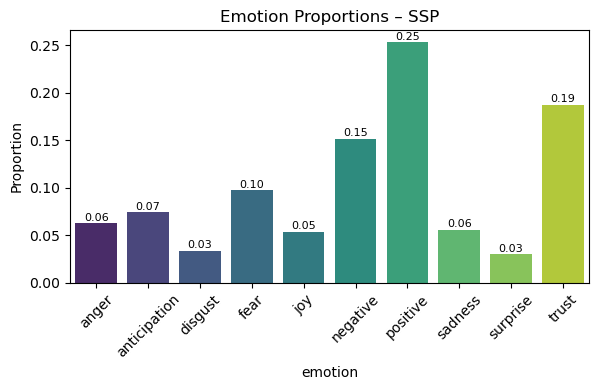

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_ssp.png


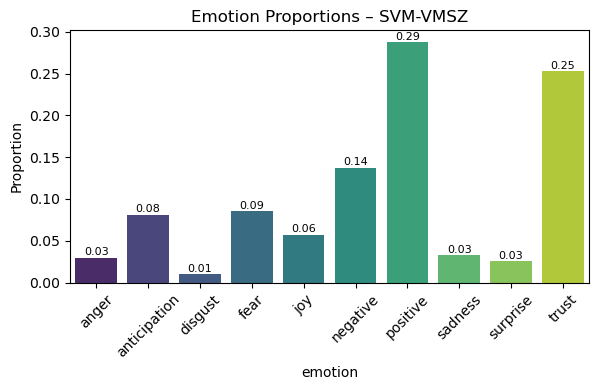

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_svm-vmsz.png


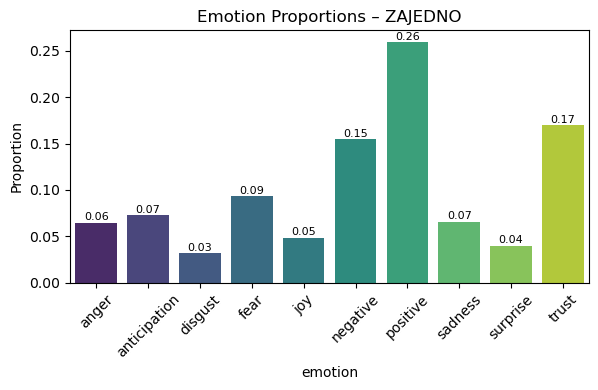

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_zajedno.png


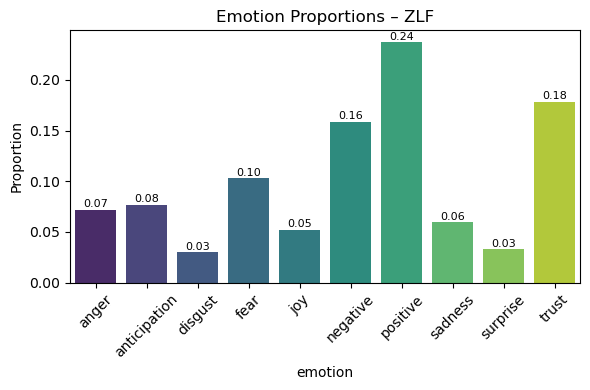

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_zlf.png


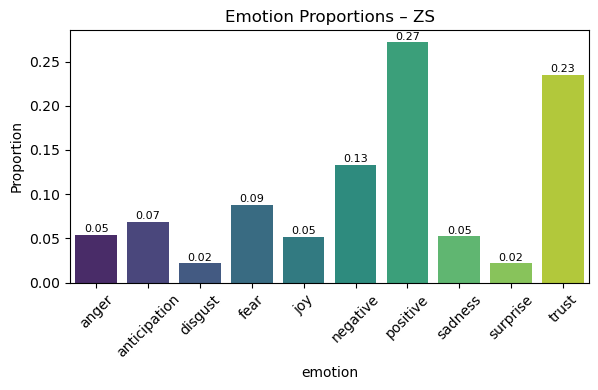

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_zs.png


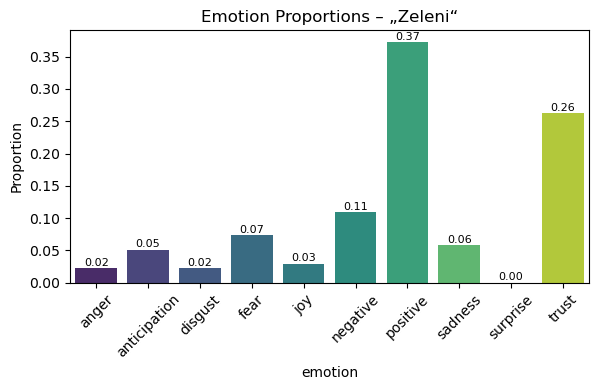

Saved: /home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures/emotions_„zeleni“.png


In [57]:
# Define your save path
output_dir = "/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/03 figures"

unique_parties = party_emotions_long['party'].unique()

for party in unique_parties:
    subset = party_emotions_long[party_emotions_long['party'] == party]

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(
        data=subset,
        x='emotion',
        y='score',
        hue='emotion',
        dodge=False,
        palette='viridis',
        legend=False
    )
    plt.title(f"Emotion Proportions – {party}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)

    # Add value labels
    for i, row in enumerate(subset.itertuples()):
        ax.text(i, row.score + 0.0005, f"{row.score:.2f}", ha='center', va='bottom', fontsize=8)
    plt.subplots_adjust(top=0.50)
    plt.tight_layout()

    # Sanitize filename
    filename = f"emotions_{party.lower().replace(' ', '_').replace('/', '_')}.png"
    full_path = os.path.join(output_dir, filename)
    plt.savefig(full_path, dpi=300)
    plt.show()  
    plt.close()

    print(f"Saved: {full_path}")

## Summary (Optional Export)

In [59]:
print(df.columns.tolist())

['file', 'speaker', 'speech', 'speech_len', 'clean_tokens', 'clean_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust', 'dominant_emotion', 'party']


In [61]:
# Export final DataFrame with clean text and sentiment
df[['speaker', 'speech', 'clean_text', 'speech_len', 'positive', 'negative', 'dominant_emotion']].to_csv(
    "/home/vuk/Documents/0 Data Science/parliament_nlp_analysis/0 data/02 interim/cleaned_speeches.csv",
    index=False
)